# Initial U-Net testing

In [6]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

### Class

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.images = sorted(os.listdir(images_dir))

        self.img_transform = T.Compose([
            T.Resize((256, 256)),
            T.ToTensor()
        ])

        self.mask_transform = T.Compose([
            T.Resize((256, 256)),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        mask_name = os.path.splitext(img_name)[0] + ".png"

        image = Image.open(os.path.join(self.images_dir, img_name)).convert("RGB")
        mask = Image.open(os.path.join(self.masks_dir, mask_name)).convert("L")

        image = self.img_transform(image)
        mask = self.mask_transform(mask)

        return image, mask.float()


### Folders

In [2]:
from torch.utils.data import DataLoader

base = "/home/liva/segmentation_resnet/data/datasets"

train_dataset = SegmentationDataset(
    images_dir=f"{base}/train/images",
    masks_dir=f"{base}/train/masks"
)

val_dataset = SegmentationDataset(
    images_dir=f"{base}/val/images",
    masks_dir=f"{base}/val/masks"
)

test_dataset = SegmentationDataset(
    images_dir=f"{base}/test/images",
    masks_dir=f"{base}/test/masks"
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


### Simple U-Net Model

- 3 encoder blocks
- BCE loss

In [3]:
import torch.nn as nn
import torch

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2)

        self.d1 = DoubleConv(3, 32)
        self.d2 = DoubleConv(32, 64)
        self.d3 = DoubleConv(64, 128)

        self.u2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.c2 = DoubleConv(128, 64)

        self.u1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.c1 = DoubleConv(64, 32)

        self.out = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        c1 = self.d1(x)
        c2 = self.d2(self.pool(c1))
        c3 = self.d3(self.pool(c2))

        x = self.u2(c3)
        x = torch.cat([x, c2], dim=1)
        x = self.c2(x)

        x = self.u1(x)
        x = torch.cat([x, c1], dim=1)
        x = self.c1(x)

        return self.out(x)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1/40, Loss: 0.5113
Epoch 2/40, Loss: 0.3744
Epoch 3/40, Loss: 0.3140
Epoch 4/40, Loss: 0.2916
Epoch 5/40, Loss: 0.2749
Epoch 6/40, Loss: 0.2757
Epoch 7/40, Loss: 0.2617
Epoch 8/40, Loss: 0.2631
Epoch 9/40, Loss: 0.2619
Epoch 10/40, Loss: 0.2512
Epoch 11/40, Loss: 0.2455
Epoch 12/40, Loss: 0.2413
Epoch 13/40, Loss: 0.2447
Epoch 14/40, Loss: 0.2393
Epoch 15/40, Loss: 0.2364
Epoch 16/40, Loss: 0.2384
Epoch 17/40, Loss: 0.2381
Epoch 18/40, Loss: 0.2377
Epoch 19/40, Loss: 0.2331
Epoch 20/40, Loss: 0.2345
Epoch 21/40, Loss: 0.2350
Epoch 22/40, Loss: 0.2313
Epoch 23/40, Loss: 0.2306
Epoch 24/40, Loss: 0.2277
Epoch 25/40, Loss: 0.2298
Epoch 26/40, Loss: 0.2284
Epoch 27/40, Loss: 0.2296
Epoch 28/40, Loss: 0.2296
Epoch 29/40, Loss: 0.2274
Epoch 30/40, Loss: 0.2276
Epoch 31/40, Loss: 0.2278
Epoch 32/40, Loss: 0.2255
Epoch 33/40, Loss: 0.2245
Epoch 34/40, Loss: 0.2240
Epoch 35/40, Loss: 0.2226
Epoch 36/40, Loss: 0.2217
Epoch 37/40, Loss: 0.2266
Epoch 38/40, Loss: 0.2218
Epoch 39/40, Loss: 0.

## Compute Mean IoU

In [ ]:
def compute_iou(pred, mask):
    pred = (pred > 0.5).float()
    mask = (mask > 0.5).float()

    intersection = (pred * mask).sum()
    union = ((pred + mask) > 0).float().sum()

    if union == 0:
        return 1.0 # if no corrosion is present

    return float((intersection / union).item())


In [ ]:
model.eval()
ious = []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks  = masks.to(device)

        # predictions
        preds = torch.sigmoid(model(images))

        # convert to binary
        preds_binary = (preds > 0.5).float()

        # compute IoU#
        iou = compute_iou(preds_binary, masks)
        ious.append(iou)

#  mean iou statistics
mean_iou = sum(ious) / len(ious)

print(f"Test set size: {len(ious)} images")
print(f"Mean IoU over test set: {mean_iou:.4f}")
print(f"IoU range: min={min(ious):.4f}, max={max(ious):.4f}")

Test set size: 31 images
Mean IoU over test set: 0.5624
IoU range: min=0.3054, max=0.7498


## Print examples of image, true mask, predicted mask

In [ ]:
# get one batch
images, masks = next(iter(val_loader))
images = images.to(device)
masks = masks.to(device)

with torch.no_grad():
    preds = model(images)
    preds = torch.sigmoid(preds)   # convert 0-1
    preds_binary = (preds > 0.5).float()  # threshold to binary mask

## Print examples of image, true mask, predicted mask

In [15]:
# get one batch
images, masks = next(iter(val_loader))
images = images.to(device)
masks = masks.to(device)

with torch.no_grad():
    preds = model(images)
    preds = torch.sigmoid(preds)   # convert 0-1
    preds_binary = (preds > 0.5).float()  # threshold to binary mask


In [17]:
def show_predictions(model, dataloader, device, n=3, threshold=0.5):
    """
    Displays n RGB images, their true masks, and predicted masks
    """
    model.eval()
    rgb_batch, mask_batch = next(iter(dataloader))
    
    rgb_batch = rgb_batch.to(device)
    
    with torch.no_grad():
        preds = torch.sigmoid(model(rgb_batch))  # probabilities
        preds = (preds > threshold).float()      # binary mask
    
    # move to CPU and convert to numpy
    rgb_batch = rgb_batch.cpu()
    mask_batch = mask_batch.cpu()
    preds = preds.cpu()
    
    for i in range(min(n, len(rgb_batch))):
        rgb_img = rgb_batch[i].permute(1,2,0).numpy()
        true_mask = mask_batch[i][0].numpy()
        pred_mask = preds[i][0].numpy()
        
        fig, axes = plt.subplots(1,3, figsize=(12,4))
        axes[0].imshow(rgb_img)
        axes[0].set_title("RGB Image")
        axes[0].axis("off")
        
        axes[1].imshow(true_mask, cmap="gray")
        axes[1].set_title("True Mask")
        axes[1].axis("off")
        
        axes[2].imshow(pred_mask, cmap="gray")
        axes[2].set_title("Predicted Mask")
        axes[2].axis("off")
        
        plt.show()

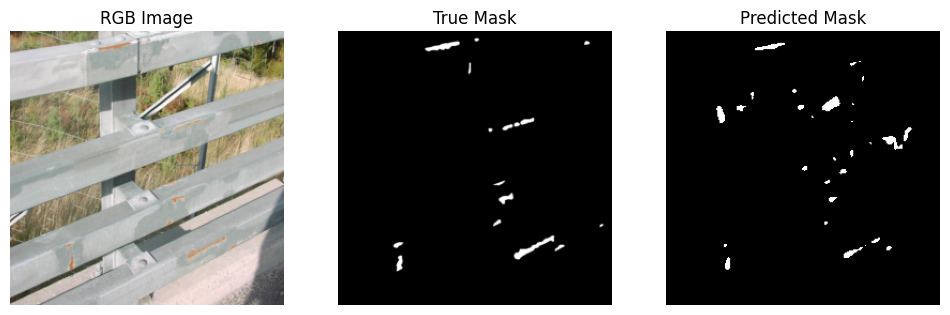

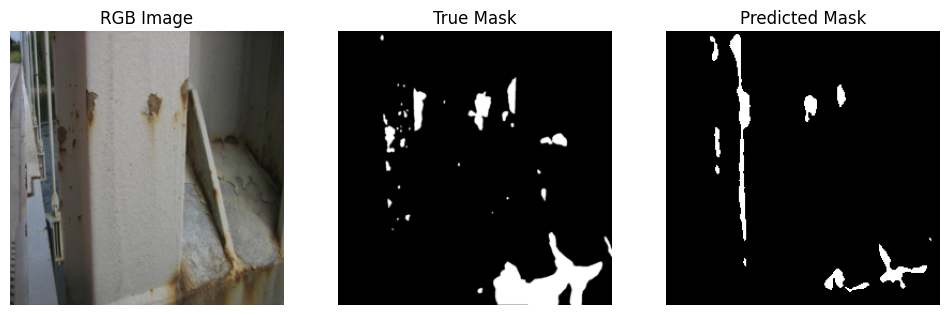

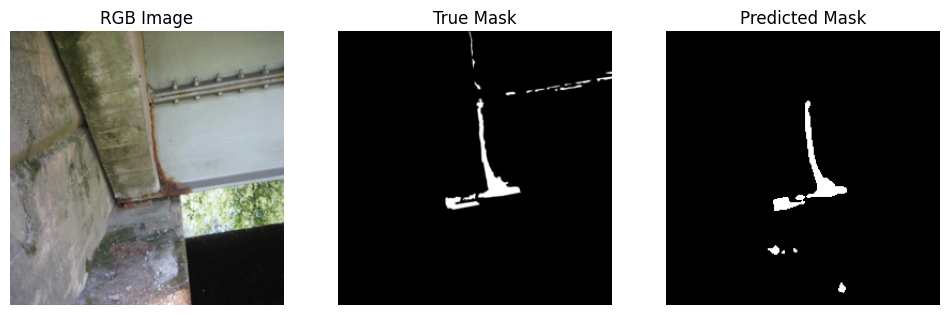

In [18]:
show_predictions(model, val_loader, device, n=3)

## Visualize specific example

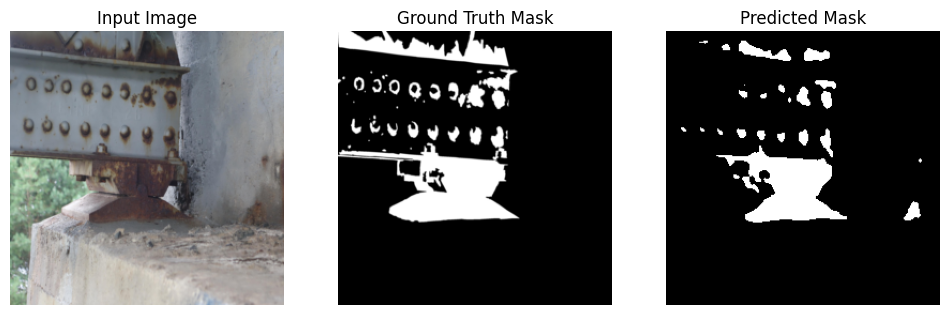

In [ ]:
# folder name
target_name = "cl725bfgn4nz9073849m9b4v4"

# get paths
img_path  = os.path.join(base, "test/images", target_name + ".jpg")  # image is jpg
mask_path = os.path.join(base, "test/masks",  target_name + ".png")  # mask is png

# load image and mask
image = Image.open(img_path).convert("RGB")
mask  = Image.open(mask_path).convert("L")

# transform to tensor (add batch dimension)
img_tensor = train_dataset.img_transform(image).unsqueeze(0).to(device)  # [1, C, H, W]
mask_tensor = train_dataset.mask_transform(mask).unsqueeze(0).to(device) # [1, 1, H, W]

# predict with model
model.eval()
with torch.no_grad():
    pred = model(img_tensor)
    pred_binary = (torch.sigmoid(pred) > 0.5).float()

# remove batch dimension
img_np = img_tensor[0].cpu().permute(1,2,0)
mask_np = mask_tensor[0].cpu().squeeze()
pred_np = pred_binary[0].cpu().squeeze()

# print
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Ground Truth Mask")
plt.imshow(mask_np, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(pred_np, cmap="gray")
plt.axis("off")
plt.show()

In [19]:
# compute IoU for this specific image
intersection = ((pred_binary > 0) & (mask_tensor > 0)).float().sum()
union = ((pred_binary > 0) | (mask_tensor > 0)).float().sum()

iou = (intersection / union).item() if union > 0 else 0.0

print(f"IoU for {target_name}: {iou:.4f}")

IoU for cl725bfgn4nz9073849m9b4v4: 0.4577
